# Biometric System for gender and age classification
Import of necessary libraries

In [ ]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from PIL import Image

#### Setting of constants and paths for the system.

In [ ]:
IMG_SIZE = 160                               # Required dimension for FaceNet
MODEL_PATH = r'PATH_TO_best_model.pth'       # Path for the model
DATASET_PATH = r"PATH_TO_demo_images"       # Path for the dataset

#### Categorization of the ages
A function that maps the age, taken from the label, in one of the eight classes.
A second function that maps the class into the range.
[(0, 2), (4, 6), (8, 13), (15, 20), (25, 32), (38, 43), (48, 53), (60, ...)]

In [ ]:
def age_to_class(age):
    if 0 <= age <= 2: return 0
    elif 4 <= age <= 6: return 1
    elif 8 <= age <= 13: return 2
    elif 15 <= age <= 20: return 3
    elif 25 <= age <= 32: return 4
    elif 38 <= age <= 43: return 5
    elif 48 <= age <= 53: return 6
    elif age >= 60: return 7
    else: return -1  # Error class

def class_to_range(class_num):
    if class_num == 0: return '0-2'
    elif class_num == 1: return '4-6'
    elif class_num == 2: return '8-13'
    elif class_num == 3: return '15-20'
    elif class_num == 4: return '25-32'
    elif class_num == 5: return '38-43'
    elif class_num == 6: return '48-53'
    elif class_num == 7: return '60+'
    else: return 'Error'  # Error range

#### Image preprocessing
Application of Gaussian blur, CLAHE and Gabor filters.

In [ ]:
def img_preprocessing(image, ksize=31, sigma=2.0, lambd=7.0, gamma=0.5, psi=0, orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4], multi_scale=True):
    # Gaussian blur for noise reduction
    smoothed_image = cv2.GaussianBlur(image, (5, 5), 1.5)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    smoothed_image = clahe.apply(smoothed_image)

    # Gabor filters for texture enhancement
    filtered_images = []
    for theta in orientations:
        for scale in [sigma, sigma*2]:
            gabor_kernel = cv2.getGaborKernel((ksize, ksize), scale, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
            filtered_image = cv2.filter2D(smoothed_image, cv2.CV_32F, gabor_kernel)
            filtered_images.append(filtered_image)
    combined_filtered_image = np.sum(filtered_images, axis=0)

    normalized_image = cv2.normalize(combined_filtered_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.uint8(np.clip(normalized_image, 0, 255))

    return normalized_image

#### Loading of the pretrained model
We developed a multitask model based on FaceNet, trained through fine-tuning technique. 

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Upload the base model (FaceNet)
base_model = InceptionResnetV1(pretrained='vggface2').to(device)

# Modification of the base model to make it multitask
class MultiTaskModel(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskModel, self).__init__()
        self.base = base_model
        self.dropout = nn.Dropout(0.2)
        self.gender_head = nn.Linear(512, 2)
        self.age_head = nn.Linear(512, 8)

    def forward(self, x):
        x = self.base(x)
        x = self.dropout(x)
        gender_output = self.gender_head(x)
        age_output = self.age_head(x)
        return gender_output, age_output

# Load the model
model = MultiTaskModel(base_model)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

model.to(device)

#### Loading of the images 

In [ ]:
img_paths = []
genders = []
age_ranges = []

for img_name in os.listdir(DATASET_PATH):
    try:
        # Extract the labes from the image name
        age, gender, *_ = img_name.split('_')  
        age = int(age)
        gender = int(gender)
        img_path = os.path.join(DATASET_PATH, img_name)

        img_paths.append(img_path)
        genders.append(gender)
        age_ranges.append(age_to_class(age))
    except Exception as e:
        continue

#### Visualization of the images with the predicted labes and the actual ones 

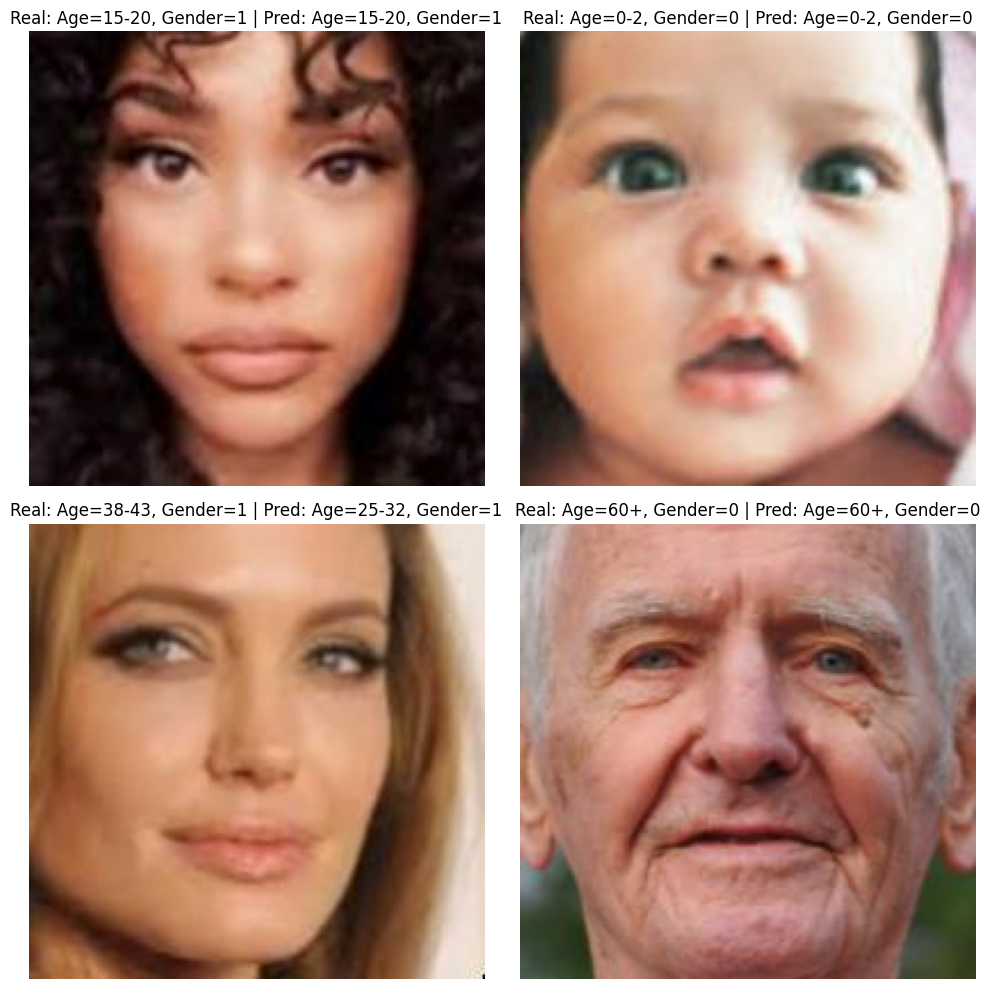

In [ ]:
# Window to visualize the images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for idx, ax in zip([0, 1, 2, 3], axes.flatten()):
    img_path = img_paths[idx]
    img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)  # Real image in RGB
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # Image for the model

    # Preprocessing for the model
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img_preprocessing(img)
    img = np.repeat(img[:,:,np.newaxis],3,axis=2)
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device) 

    # Prediction with the model
    with torch.no_grad():
        gender_pred, age_pred = model(img_tensor)
        gender_pred = gender_pred.argmax(1).item()  
        age_pred = age_pred.argmax(1).item() 
        age_pred = class_to_range(age_pred)

    # Real labels
    real_gender = genders[idx]
    real_age = class_to_range(age_ranges[idx])

    # Visualize the image without preprocessing
    ax.imshow(img_rgb)
    ax.axis('off')

    # Labels
    ax.set_title(f"Real: Age={real_age}, Gender={real_gender} | Pred: Age={age_pred}, Gender={gender_pred}")

plt.tight_layout()
plt.show()